In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import random

filepath = '/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Project 4/data/nfl_games.csv'
rawData = pd.read_csv(filepath, delimiter = ',')

After importing our data and necessary packages, we will begin feature engineering. The first thing that stood out to me is that I wanted a way to preserve the score difference after I reshaped the data. So, I added a $\texttt{'ScoreDif'}$ variable.

In [29]:
rawData['ScoreDif'] = rawData['score1'] - rawData['score2']

The approach we'll be taking is given a team, we want to create a regression model for predicting their score in a game. To do this, we want to strip the dataset into two separate datasets. One dataset for $\texttt{team1}$ and one for $\texttt{team2}$. We also rename the columns to concatonate the data later.

In [30]:
games1 = pd.DataFrame(rawData, columns = ['season', 'playoff', 'team1', 'elo1', 'ScoreDif', 'score1']).rename(
    columns={'team1':'team', 'elo1':'elo', 'score1':'score'})
games2 = pd.DataFrame(rawData, columns = ['season', 'playoff', 'team2', 'elo2', 'ScoreDif', 'score2']).rename(
    columns={'team2':'team', 'elo2':'elo', 'score2':'score'})

Another aspect of football games that I would like to capture in this data is whether they are playing at home or not. The first team is at home so we set the $\texttt{home}$ column to $1$.

In [31]:
games1['home'] = 1
games2['home'] = 0

Now we want to concatonate this data.

In [32]:
games = pd.concat([games1, games2])

When I was working on this part, I noticed that some teams don't have very many games recorded. So, I created a dataset to count the number of games each team has. Then, I filtered out all the teams that don't have at least 100 games recorded.

In [33]:
teams = list(games.team.unique())
noGames = games['team'].value_counts()
noGames = pd.DataFrame(noGames.where(noGames > 100).dropna())
incTeams = list(noGames.index)

games = games[games['team'].isin(incTeams)]

To understand the range of football scores that we have in this dataset, I plotted a histogram of the scores.

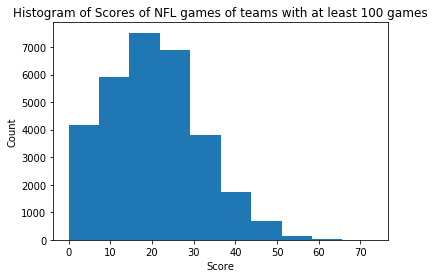

In [34]:
plt.hist(games['score'])
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Histogram of Scores of NFL games of teams with at least 100 games')
plt.show()

Linear Regression.

The first regression model we're building is a simple linear regression model. I defined a function that runs a simple linear regression 100 times and then we can plot the $R^2$ values that we get from all of these runs. We choose a random team and build 100 regression models for this team. I originally ran this with the playoff variable, but found that it worked consistently better without it, so we removed it for the project.

In [35]:
def predictScoreLR(team):
    teamL = [team]
    teamData = games[games['team'].isin(teamL)]
    X = teamData.drop(columns = ['team', 'score', 'season', 'playoff'])
    y = teamData['score']
    data = []
    for i in range(100):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2)
        reg = LinearRegression()
        reg.fit(x_train, y_train)
        data.append(reg.score(x_test,y_test))
    return data
    
team = random.choice(incTeams)
scores = predictScoreLR(team)

We can then plot these scores (by score we mean the $R^2$ value of the build, not the score of the game).

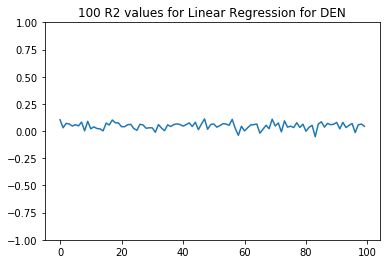

In [36]:
plt.plot(list(range(100)), scores)
plt.title('100 R2 values for Linear Regression for ' + team)
plt.ylim(-1,1)
plt.show()

Based on these $R^2$ values we can see that a simple linear regression model isn't doing a very good job explaining the variance of scores. Linear Regression has a limited ability to predict the scores, so I think even with our relatively simple dataset it's not going to work much better than what we have. So, we want to approach a different method.

Gradient Boosting.

The next method that we are going to attempt is to apply a gradient boosting model to our data. Similar to above, we have a function that will run 100 regressions and then we can plot the scores.

In [41]:
def predictScoreGB(team):
    teamL = [team]
    teamData = games[games['team'].isin(teamL)]
    X = teamData.drop(columns = ['team', 'score', 'season', 'playoff'])
    y = teamData['score']
    data = []
    for i in range(100):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2)
        reg = GradientBoostingRegressor(random_state=0)
        reg.fit(x_train,y_train)
        score = reg.score(x_test, y_test)
        data.append(score)
    return data
    
team = random.choice(incTeams)
scores = predictScoreGB(team)

We then plot the $R^2$ values for this.

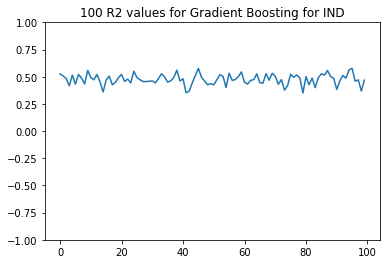

In [42]:
plt.plot(list(range(100)), scores)
plt.title('100 R2 values for Gradient Boosting for ' + team)
plt.ylim(-1,1)
plt.show()

Immediately we see that this method works much better than our simple linear regression. 

As I was working on these models, I thought about a lot of different variables that could help increase the accuracy of these. I considered encoding which team the given team was playing against, but similarly to the playoff variable, it added information but decreased the accuracy of the model. This made me wonder if other variables were causing the model to drop in accuracy. I was most curious about how the variable I create $\texttt{ScoreDif}$ affected the accuracy.

I modified our gradient boosting model to drop the $\texttt{ScoreDif}$ variable and ran it again on the same team from above to compare our results.

In [47]:
def predictScoreGB_woSD(team):
    teamL = [team]
    teamData = games[games['team'].isin(teamL)]
    X = teamData.drop(columns = ['team', 'score', 'season', 'playoff', 'ScoreDif'])
    y = teamData['score']
    data = []
    for i in range(100):
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2)
        reg = GradientBoostingRegressor(random_state=0)
        reg.fit(x_train,y_train)
        score = reg.score(x_test, y_test)
        data.append(score)
    return data
scores = predictScoreGB_woSD(team)

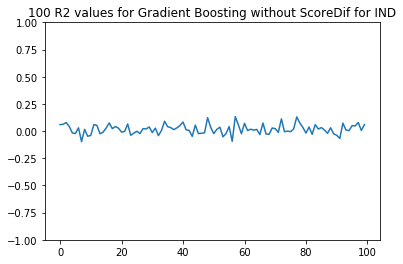

In [48]:
plt.plot(list(range(100)), scores)
plt.title('100 R2 values for Gradient Boosting without ScoreDif for ' + team)
plt.ylim(-1,1)
plt.show()

We can see that removing this variable decreases the accuracy a huge amount, so we know it's an important variable in explaining the the scores of teams.